# Simulating a vesicle

## Overview

### Questions

* How do I include triangulated meshes in HOOMD?
* How can I apply mesh potentials to the simulations?

### Objectives

- Create a spherical mesh and include it to the hoomd simulations.
- Run simulations with fixed area to volume ratio.

## Boilerplate Code

In [1]:
import math
import warnings

import fresnel
import gsd.hoomd
import hoomd
import IPython
import numpy
import packaging.version
from scipy.spatial import ConvexHull

The `render` function in the next (hidden) cell will render a snapshot using **fresnel**. Find the source in the [hoomd-examples](https://github.com/glotzerlab/hoomd-examples) repository.

In [2]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if (
        "version" not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    central_color = fresnel.color.linear([252 / 255, 41 / 255, 0 / 255])

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=0.5
    )
    geometry.material = fresnel.material.Material(
        color=[0, 0, 0], roughness=0.5, primitive_color_mix=1.0
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.color[snapshot.particles.typeid[:] == 0] = central_color
    geometry.radius[snapshot.particles.typeid[:] == 0] = 0.25
    geometry.outline_width = 0.01
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

### Creating the mesh vertices using the Fibonacci sphere

Let's run a simulation with a spherical mesh. We first must define the positions of the mesh vertices on the sphere with radius R. As shown in the previous section, use the Fibonacci sphere to initialize the mesh.

In [3]:
# Number of vertices in the mesh
N_mesh = 1600

indices = numpy.arange(0, N_mesh, dtype=float) + 0.5

phi = numpy.arccos(1 - 2 * indices / N_mesh)
theta = numpy.pi * (1 + 5**0.5) * indices

# radius of the vesicle
R = 10

x, y, z = (
    R * numpy.cos(theta) * numpy.sin(phi),
    R * numpy.sin(theta) * numpy.sin(phi),
    R * numpy.cos(phi),
)

vertex_positions = numpy.column_stack((x, y, z))

hull = ConvexHull(vertex_positions)
triangle_tags = hull.simplices

N_triangles = triangle_tags.shape[0]
for i in range(len(triangle_tags)):
    normal = numpy.cross(
        vertex_positions[triangle_tags[i, 0]] - vertex_positions[triangle_tags[i, 2]],
        vertex_positions[triangle_tags[i, 0]] - vertex_positions[triangle_tags[i, 1]],
    )
    if numpy.dot(vertex_positions[triangle_tags[i, 0]], normal) < 0:
        triangle_tags[i, 1], triangle_tags[i, 2] = (
            triangle_tags[i, 2],
            triangle_tags[i, 1],
        )

### Set up frame:

To integrate a mesh in HOOMD, we first define the vertices as particles. Vertex particles can be added to the simulation in addition to other particles that do not belong to the mesh.

In [4]:
frame = gsd.hoomd.Frame()
frame.particles.N = N_mesh
frame.particles.position = vertex_positions
frame.particles.typeid = [0] * N_mesh
frame.configuration.box = [25, 25, 25, 0, 0, 0]
frame.particles.types = ["vertex"]

### Set up simulation

We can now initialize the simulation with the vertex particles and prepare a Brownian dynamics simulation.

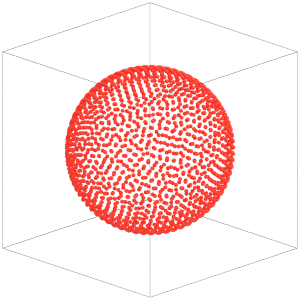

In [5]:
with gsd.hoomd.open(name="initial_mesh.gsd", mode="w") as f:
    f.append(frame)

CPU = hoomd.device.CPU()
simseed = 1
sim = hoomd.Simulation(device=CPU, seed=simseed)
state = sim.create_state_from_gsd(filename="initial_mesh.gsd")

integrator = hoomd.md.Integrator(dt=0.001)
sim.operations.integrator = integrator
filter_all = hoomd.filter.All()

kT = 0.2
brownian = hoomd.md.methods.Brownian(filter=filter_all, kT=kT)
brownian.gamma.default = 50
integrator.methods.append(brownian)

render(sim.state.get_snapshot())

### Initialize mesh object:

The mesh object is defined by a triangulation which dictates edges between the vertices and the mesh topology. As described previously, each triangle is described by a triplet of indices. In the simulation these indices refer to the particle indices. Hence, if the simulation contains more than just vertex type particles, the user should make sure that the vertex particles are defined before the other types of particles.  

Each triangle is assigned a triangle type `mesh`. The triangle type is used to define parameters of mesh potentials and is independent of the particle type. Additionally the bond strength `k_b` can be related to the Young's modulus of the membrane $Y = \frac{2}{\sqrt{3}}k_b$.

The mesh object stores the mesh topology only internally and cannot be written directly into gsd or other file formats. Therefore, the topology needs to be provided separately.

In [6]:
mesh_obj = hoomd.mesh.Mesh()
mesh_obj.types = ["mesh"]
mesh_obj.triangulation = dict(type_ids=[0] * N_triangles, triangles=triangle_tags)

## Add mesh potentials

In the following we define different mesh potentials. These potentials depend on the vertex particle positions and the topology of the mesh.

### Bond potentials

Bond potentials act on all vertex pairs connected with an edge. Users should always define a bond potential to avoid self-intersections between neighboring triangles.

For most bond potentials it is important that the mesh edge lengths are initialized close to the equilibrium length. Hence, it is advisable to check the minimal and maximal edge lengths to avoid large forces or out of bound errors.

In [7]:
# check that edge lengths are in the tether window
triangle_cartesian_positions = frame.particles.position[triangle_tags]
global_max_edge = numpy.linalg.norm(
    triangle_cartesian_positions[:, 0] - triangle_cartesian_positions[:, 1], axis=1
).max()
global_min_edge = numpy.linalg.norm(
    triangle_cartesian_positions[:, 0] - triangle_cartesian_positions[:, 1], axis=1
).min()
global_mean = numpy.linalg.norm(
    triangle_cartesian_positions[:, 0] - triangle_cartesian_positions[:, 1], axis=1
).mean()

global_max_edge, global_min_edge, global_mean

(np.float32(1.2657272), np.float32(0.77298886), np.float32(0.98328316))

### Add bond tether potential to mesh

In the following we will use the bond tether potential where edge neighboring vertices move freely within a distance window between `l_c1` and `l_c0`. Additionally, the edge lengths must lie between `l_min` and `l_max`. 

![Helfrich-Plot](Helfrich_plot.svg)

Hence, we define these parameters so `global_max_edge` and `global_min_edge` lie well within the latter distance window.

In [8]:
# Define medium edge length between vertices
sigma = 1

# Define tether parameter
l_min = (2 / 3) * sigma
l_c1 = 0.85 * sigma
l_c0 = 1.15 * sigma
l_max = (4 / 3) * sigma

# bond strength
k_bond = 100

mesh_bond_potential = hoomd.md.mesh.bond.Tether(mesh_obj)
mesh_bond_potential.params["mesh"] = dict(
    k_b=k_bond, l_min=l_min, l_c1=l_c1, l_c0=l_c0, l_max=l_max
)
integrator.forces.append(mesh_bond_potential)

### Repulsive potential between vertices

To avoid self-intersections of different parts of the mesh we can apply between the vertex particles. Pass the `mesh_obj` to the neighbor list and set the `"meshbond"` exclusion to exclude repulsive forces between vertices in the same triangle.

In [9]:
cell = hoomd.md.nlist.Cell(buffer=0.4, mesh=mesh_obj, exclusions=("meshbond",))

lj = hoomd.md.pair.LJ(nlist=cell, mode="shift")
lj.params[("vertex", "vertex")] = dict(epsilon=1, sigma=sigma)
lj.r_cut[("vertex", "vertex")] = 2 ** (1.0 / 6.0) * sigma
integrator.forces.append(lj)

### Bending potentials

Another class of potentials are mesh bending potentials. These potentials apply a penalty to mean curvature $H$ across the membrane surface $S$:

$$
U_H = 2 k \oint_{S}{\mathbf{H}^2 \cdot d\mathbf{S}}.
$$

The bend potential strength `k` also dictates the bending modulus of the membrane $\kappa = \frac{\sqrt{3}}{2}k$. Without a bending potential the mesh is highly floppy and Brownian motion will roughen the vesicle surface.

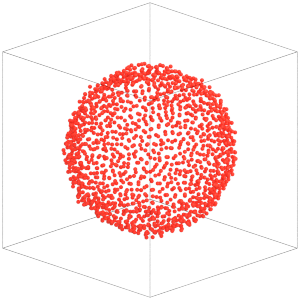

In [10]:
sim.run(50000)
render(sim.state.get_snapshot())

### Add Helfrich bending potential to mesh

In the following we will use the Helfrich potential which calculates $H$ at every vertex particle. Helfrich forces are computationally expensive but most accurately represent the bending forces of lipid vesicles. Other bending potentials, while approximating $H$ slightly looser, are faster and should be used for meshes with number of vertices `N_mesh`>10000.

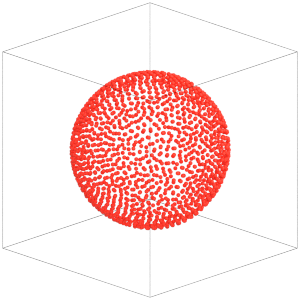

In [11]:
# bending strength
k_bend = 100

helfrich_rigidity = hoomd.md.mesh.bending.Helfrich(mesh_obj)
helfrich_rigidity.params["mesh"] = dict(k=k_bend)
integrator.forces.append(helfrich_rigidity)

sim.run(50000)
render(sim.state.get_snapshot())

### Add area conservation to mesh

The last class of mesh potentials are conservation potentials such as the area conservation potential. These potentials apply are local (per triangle) or global (per mesh type) harmonic constraint to the mesh.

Mesh surface area before applying an area constraint 0.877238046366799
Mesh surface area after applying an area constraint 0.996256773914653


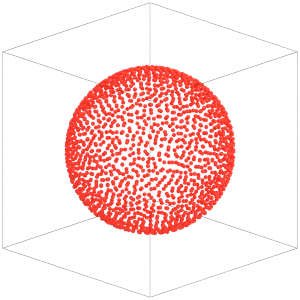

In [12]:
# strength of the harmonic area conservation potential
k_area = 1000

# Define target area
Area = 4 * numpy.pi * R**2

area_potential = hoomd.md.mesh.conservation.Area(mesh_obj)
area_potential.params["mesh"] = dict(k=k_area, A0=Area)
integrator.forces.append(area_potential)

sim.run(0)
before_area_constraint = area_potential.area / Area
print("Mesh surface area before applying an area constraint", before_area_constraint[0])

sim.run(20000)
after_area_constraint = area_potential.area / Area
print("Mesh surface area after applying an area constraint", after_area_constraint[0])

render(sim.state.get_snapshot())

### Add volume conservation to mesh

Another conservation potential constrains the volume of the mesh. This constraint should be used if the mesh represents a droplet or if there is no mass transfer between the inside and outside of the vesicle. Here we define a droplet that has 85% of a sphere volume with radius `R`.

120000 1.167917894515523
130000 1.0135386523876921
140000 1.0078114360922177
150000 1.0065743831234735


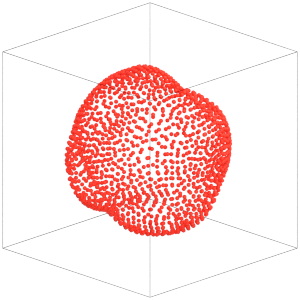

In [13]:
# Define target volume
Volume = 4 / 3 * numpy.pi * R**3 * 0.85

volume_potential = hoomd.md.mesh.conservation.Volume(mesh_obj)
volume_potential.params["mesh"] = dict(k=1000, V0=Volume)
integrator.forces.append(volume_potential)

sim.run(0)
print(sim.timestep, volume_potential.volume[0] / Volume)

for _ in range(3):
    sim.run(10000)
    print(sim.timestep, volume_potential.volume[0] / Volume)

render(sim.state.get_snapshot())